In [1]:
import numpy as np
import copy
from scipy import misc
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
%matplotlib inline
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, CyclicLR, ReduceLROnPlateau, LinearLR, ExponentialLR
import random
from torch.autograd.functional import jacobian#, hessian
# import AUTOGRAD.FUNCTIONAL.JACOBIAN as jacobian
import time
# import math

import matplotlib as mpl
# from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
mpl.rcParams['legend.fontsize'] = 10
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
!python -V

Python 3.11.7


# Random sample generation

In [3]:
t0 = time.time()
num_samples = 2**16
num_time_intervals=20
dim = 10
size = num_samples* dim * num_time_intervals
iid = torch.randn(size=[size]).to(device)
print("It takes {:.0f} ms to generate {:,} iid samples.".format(round(1000*(time.time()-t0),6),size))


It takes 136 ms to generate 13,107,200 iid samples.


In [4]:
num= 2**10
n=10
d = 3
iid[0:num*n*d].reshape([num,d,n])

tensor([[[ 6.2216e-01, -9.5906e-01,  3.9402e-01,  ..., -5.0424e-01,
           1.5955e+00, -1.7776e+00],
         [ 1.0242e+00, -1.7916e+00, -3.9988e-01,  ..., -1.3228e-01,
           1.0701e+00,  9.5674e-02],
         [-1.2295e-01, -1.7562e-01,  8.9438e-01,  ..., -1.9275e+00,
          -1.4300e+00,  6.5120e-01]],

        [[ 8.8511e-01,  1.3866e+00, -7.6297e-01,  ..., -1.5541e-01,
           5.3276e-01,  3.3915e-01],
         [-6.2412e-01,  6.0796e-01, -2.0771e-01,  ...,  4.5905e-01,
           6.1466e-01, -1.3174e-01],
         [-1.2014e-01, -6.4440e-01, -1.4411e+00,  ...,  9.2157e-01,
           3.2332e-01, -1.0575e+00]],

        [[-1.7569e+00,  1.3353e-01,  3.3778e-01,  ..., -6.7177e-01,
           7.6498e-02,  1.2314e+00],
         [ 4.5717e-01, -6.6816e-01,  5.4684e-01,  ..., -2.4782e+00,
          -1.9560e+00, -1.2095e+00],
         [-6.7002e-01, -1.9264e+00, -1.2813e+00,  ..., -4.9412e-01,
          -1.2854e+00,  5.3136e-02]],

        ...,

        [[ 2.1272e+00,  1.3732e-03,

# Parameters of the PDEs

In [5]:
dim=2 # dim = n+1, n assets, 1 wealth + n stochastic volatilites. does not include time
# nonlinear PDE
pde_params={'dim':dim,
          'kappa':torch.tensor([0.,1.,0.8,0.6,0.4,0.5,0.3,0.2,0.1,0.7]).to(device), # The first kappa=0 because the drift of wealth process is zero
          'theta':torch.tensor([0.,0.1,0.2,0.3,0.4,0.5,0.4,0.3,0.2,0.1]).to(device),
          'nu':torch.tensor([0.02,0.015,0.11,0.12,0.01,0.013,0.14,0.14,0.01]).to(device),
          'lb':torch.tensor([0.,0.15,0.11,0.12,0.13,0.15,0.11,0.12,0.13,0.15]).to(device),   
          'rho':torch.tensor([0.,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]).to(device),
          'eta':torch.tensor([1.]).to(device),
          'T': torch.tensor([1.]).to(device),
        }
# nonlinear PDE with OU processes
pde_params0={'dim':dim,
          'kappa':torch.tensor([0.,0.,0.,0.,0.,0.,0.,0.,0.,0.]).to(device), # The first kappa=0 because the drift of wealth process is zero
          'theta':torch.tensor([0.,0.1,0.2,0.3,0.4,0.5,0.4,0.3,0.2,0.1]).to(device),
          'nu':torch.tensor([0.02,0.015,0.11,0.12,0.01,0.013,0.14,0.14,0.01]).to(device),
          'lb':torch.tensor([0.,0.15,0.11,0.12,0.13,0.15,0.11,0.12,0.13,0.15]).to(device),   
          'rho':torch.tensor([0.,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]).to(device),
          'eta':torch.tensor([1.]).to(device),
          'T': torch.tensor([1.]).to(device),
        }

In [6]:
x_tmp = torch.rand(2,dim+1)#test data. includes time variable
x_tmp.shape

torch.Size([2, 3])

# Parameters of simulation

In [7]:
sim_params={'num_samples':2**14,
          'num_time_intervals': 20,
          'iid':iid,
          'start' : torch.tensor([0.0]),  
          'end' : torch.tensor([1.0])
        }

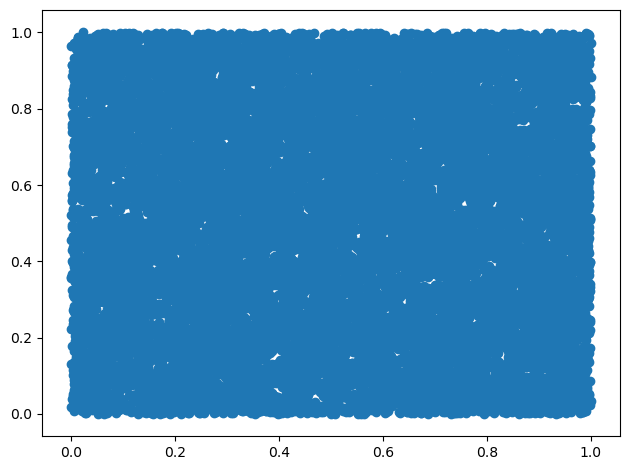

In [8]:
a = sim_params['start']
b = sim_params['end']
x0 = a+(b-a)*torch.rand(sim_params['num_samples'],dim).to(device)
plt.scatter(x0[:,0].numpy(),x0[:,dim-1].numpy());
plt.tight_layout(rect=[0,0,1,1]);

# Autograd for gradient and Hessian

## Gradient

In [9]:
def der1(x,f):  #output= [M,D,1], input: x=[M,D,1]
  Du=torch.zeros(x.shape[0],dim).to(device)
  xin=x.clone().detach()
  xin.requires_grad=True
  # print('xin shape', xin.shape)
  u=f(xin)
  # print(u)
  # print('u/f(xin) shape', u.shape)
  Du=torch.autograd.grad(outputs=[u],inputs=[xin],grad_outputs=torch.ones_like(u),
                          allow_unused=True,retain_graph=True,create_graph=True)[0].unsqueeze(2)
  # print('Du shape before reshaped', Du.shape)
  Du=torch.reshape(Du,(Du.shape[0],dim,1))
  # print('Du shape after reshaped', Du.shape)
  return Du

In [10]:
def grad_model(t, x,f_): #output= [M,D,1], #input: x=[M,D], t=[M,1], xt= [M,D+1]
    # hess_temp=torch.zeros(x.shape[0],dim,dim).to(device)
    Du=torch.zeros(x.shape[0],dim).to(device)
    xin=x.clone().detach()
    xin.requires_grad=True
    # print("xin_shape", xin.shape)
    tin=t.clone().detach()
    # print("tin shape", tin.shape)
    xt_in=torch.cat((xin,tin),1)
    # print("xt_in shape", xt_in.shape)
    # xt_in.requires_grad=True
    u=f_(xt_in)
    # print("u shape: ",u.shape)
    Du=torch.autograd.grad(outputs=[u],inputs=[xin],grad_outputs=torch.ones_like(u),
                           allow_unused=True,retain_graph=True,create_graph=True)[0].unsqueeze(2)
    Du = torch.reshape(Du,(Du.shape[0],dim,1))
    # print("Du after reshape:",Du.shape)
    return Du

##  First derivative

In [11]:
def grad_model(t, x,f_): #output= [M,D,1], #input: x=[M,D], t=[M,1], xt= [M,D+1]
    # hess_temp=torch.zeros(x.shape[0],dim,dim).to(device)
    Du=torch.zeros(x.shape[0],dim).to(device)
    xin=x.clone().detach()
    xin.requires_grad=True
    # print("xin_shape", xin.shape)
    tin=t.clone().detach()
    # print("tin shape", tin.shape)
    xt_in=torch.cat((xin,tin),1)
    # print("xt_in shape", xt_in.shape)
    # xt_in.requires_grad=True
    u=f_(xt_in)
    # print("u shape: ",u.shape)
    Du=torch.autograd.grad(outputs=[u],inputs=[xin],grad_outputs=torch.ones_like(u),
                           allow_unused=True,retain_graph=True,create_graph=True)[0].unsqueeze(2)
    Du = torch.reshape(Du,(Du.shape[0],dim,1))
    # print("Du after reshape:",Du.shape)
    return Du

## Gradient

In [12]:
def der1(x,f):  #output= [M,D,1], input: x=[M,D,1]
  Du=torch.zeros(x.shape[0],dim).to(device)
  xin=x.clone().detach()
  xin.requires_grad=True
  # print('xin shape', xin.shape)
  u=f(xin)
  # print(u)
  # print('u/f(xin) shape', u.shape)
  Du=torch.autograd.grad(outputs=[u],inputs=[xin],grad_outputs=torch.ones_like(u),
                          allow_unused=True,retain_graph=True,create_graph=True)[0].unsqueeze(2)
  # print('Du shape before reshaped', Du.shape)
  Du=torch.reshape(Du,(Du.shape[0],dim,1))
  # print('Du shape after reshaped', Du.shape)
  return Du

In [13]:
def grad_fn2(x,z,a,f,xx=False,r=False,p=False,alpha=False):  #output= [M,D,1], input: x=[M,D,1] z=[M,D,1], a=[M,D,D]
  Du=torch.zeros(x.shape[0],dim).to(device)
  xin=x.clone().detach()
  xin.requires_grad=True
  # print('xin shape', xin.shape)
  zin=z.clone().detach()
  zin.requires_grad=True
  # print('zin shape', zin.shape)
  ain=a.clone().detach()
  ain.requires_grad=True
  # print('ain shape', ain.shape)
  # ain=torch.reshape(ain,(num_sample,dim*dim,1))
  u=f(xin,zin,ain)
  # print(u)
  # print('u/f(xin) shape', u.shape)
  if xx==True:
    Du=torch.autograd.grad(outputs=[u],inputs=[xin],grad_outputs=torch.ones_like(u),
                            allow_unused=True,retain_graph=True,create_graph=True)[0]
    # print('Du shape before reshaped', Du.shape)
    Du=torch.reshape(Du,(Du.shape[0],dim,1))
    # print('Du shape after reshaped', Du.shape)
  if r==True:
    Du=torch.autograd.grad(outputs=[u],inputs=[rin],grad_outputs=torch.ones_like(u),
                            allow_unused=True,retain_graph=True,create_graph=True)[0]
    # print('Du shape before reshaped', Du.shape)
    Du=torch.reshape(Du,(Du.shape[0],1,1))
    # Du=torch.reshape(Du,(Du.shape[0],dim,dim))
    # print('Du shape after reshaped', Du.shape)
  if p==True:
    Du=torch.autograd.grad(outputs=[u],inputs=[zin],grad_outputs=torch.ones_like(u),
                            allow_unused=True,retain_graph=True,create_graph=True)[0]
    # print('Du shape before reshaped', Du.shape)
    Du=torch.reshape(Du,(Du.shape[0],dim,1))
    # print('Du shape after reshaped', Du.shape)
  if alpha==True:
    Du=torch.autograd.grad(outputs=[u],inputs=[ain],grad_outputs=torch.ones_like(u),
                            allow_unused=True,retain_graph=True,create_graph=True)[0]
    # print('Du shape before reshaped', Du.shape)
    Du=torch.reshape(Du,(Du.shape[0],dim,dim))
    # print('Du shape after reshaped', Du.shape)
  return Du

## Jacobian

In [14]:
class sample_Znet(nn.Module): #input [M,D+1]   #output [M,1]
    def __init__(self):
        super(sample_Znet, self).__init__()
        self.linear_stack = nn.Sequential(
            nn.Linear(dim+1, 10),
            # nn.BatchNorm1d(num_features=20),
            nn.Tanh(),
            nn.Linear(10,dim),
        )
    def forward(self, x):
        logits = self.linear_stack(x)
        return logits#.reshape([dim,dim])       
dv = sample_Znet()
def test_fnc(x):
    return x[:,1:]*x[:,1:] + torch.sin(torch.tensor([2])*torch.pi*x[:,1:])

In [15]:
input = x_tmp
print(input.shape,dim)
test_fnc(input).shape

torch.Size([2, 3]) 2


torch.Size([2, 2])

In [16]:
torch.sin(2*torch.pi*input)

tensor([[-0.8429,  0.0404,  0.3658],
        [-0.1412,  0.3076,  0.8546]])

In [17]:
output = jacobian(test_fnc, input)
print(input.shape, test_fnc(input).shape,output.shape)
for i in range(input.shape[0]):
    if i == 0:
        jac = output[0,:,0,1:].unsqueeze(0)# output[0,:,0,1:] eliminates the derivative wrt the first compinent, i.e., time derivative
        # print(output[i,:,i,:])
    else:
        # print(output[i,:,i,:].unsqueeze(0))
        jac = torch.cat((jac,output[i,:,i,1:].unsqueeze(0)))
print("Jacobians Tensor:\n", jac.shape)

torch.Size([2, 3]) torch.Size([2, 2]) torch.Size([2, 2, 2, 3])
Jacobians Tensor:
 torch.Size([2, 2, 2])


In [18]:
output[0,:,0,1:].shape

torch.Size([2, 2])

Jacobian of a function from $\mathbb{R}^d$ to $\mathbb{R}^d$, excludes time derivative

In [19]:
def sqr_jacobian(func,x):#Jacobian of a function from R^d to R^d
    xin=x.clone().detach()
    xin.requires_grad=True
    out = jacobian(func, xin)
    for i in range(input.shape[0]):
        if i == 0:
            jac = out[i,:,i,1:].unsqueeze(0)
            # print(output[i,:,i,:])
        else:
            # print(output[i,:,i,:].unsqueeze(0))
            jac = torch.cat((jac,out[i,:,i,1:].unsqueeze(0)))
    return jac
    

In [20]:
sqr_jacobian(test_fnc, input).shape

torch.Size([2, 2, 2])

## Hessian

In [21]:
def hessian_model(t,x,model):
    hess_temp=torch.zeros(x.shape[0],dim,dim).to(device)
    Du=torch.zeros(x.shape[0],dim).to(device)

    xin=x.clone().detach()
    xin.requires_grad=True
    # print("xin_shape", xin.shape)
    tin=t.clone().detach()
    # print("tin shape", tin.shape)
    xt_in=torch.cat((xin,tin),1)
    # print("xt_in shape", xt_in.shape)
    Du = model(xt_in)
    hess_temp= torch.cat([ torch.autograd.grad(outputs=[Du[:,i]],inputs=[xin],grad_outputs=torch.ones_like(Du[:,i]),
                           allow_unused=True,retain_graph=True,create_graph=True)[0] for i in range(dim)],1)

    # print("D2u shape:",hess_temp.shape)

    hess_temp=torch.reshape(hess_temp,(hess_temp.shape[0],dim,dim))

    # print(hess_temp)
    return hess_temp



In [22]:

def hessian1(x,model2z):  #x=[M,D,1]  output= [M,D,1]
    hess_temp=torch.zeros(x.shape[0],dim,dim).to(device)
    # print("D2u shape:",hess_temp.shape)

    Du=torch.zeros(x.shape[0],dim).to(device)
    xin=x.clone().detach()
    # print('this is xin')
    # print(xin)
    xin.requires_grad=True
    Du = model2z(xin.squeeze(2))
    # print('this is Du')
    # print(Du)
    # print('this is Du shape')
    # print(Du.shape)
    # print('this is Du 1')
    # print(Du[:,1,:])
    hess_temp= torch.cat([ torch.autograd.grad(outputs=[Du[:,i,:]],inputs=[xin],grad_outputs=torch.ones_like(Du[:,i,:]),
                           allow_unused=True,retain_graph=True,create_graph=True)[0] for i in range(dim)],1)

    # print("D2u shape:",hess_temp.shape)

    hess_temp=torch.reshape(hess_temp,(hess_temp.shape[0],dim,dim))

    # print(hess_temp)
    return hess_temp




## First and second derivative together

In [23]:
def Grad_Hess(x,v): #output= [M,D,D], #input: x=[M,D], t=[M,1], xt= [M,D+1]
    hess_temp=torch.zeros(x.shape[0],dim,dim).to(device)
    Du=torch.zeros(x.shape[0],dim).to(device)
    xin=x.clone().detach()
    xin.requires_grad=True
    u=v(xin)
    Du=torch.autograd.grad(outputs=[u],inputs=[xin],grad_outputs=torch.ones_like(u),
                           allow_unused=True,retain_graph=True,create_graph=True)[0].unsqueeze(2)
    hess_temp= torch.cat([ torch.autograd.grad(outputs=[Du[:,i,:]],inputs=[xin],grad_outputs=torch.ones_like(Du[:,i,:]),
                           allow_unused=True,retain_graph=True,create_graph=True)[0] for i in range(dim)],1)
    Du = torch.reshape(Du,(Du.shape[0],dim,1))
    hess_temp=torch.reshape(hess_temp,(hess_temp.shape[0],dim,dim))
    return Du, hess_temp



In [24]:
x_tmp.shape

torch.Size([2, 3])

In [25]:
class sample_Ynet(nn.Module): #input [M,D+1]   #output [M,1]
    def __init__(self):
        super(sample_Ynet, self).__init__()
        self.linear_stack = nn.Sequential(
            nn.Linear(dim, 10),
            nn.Sigmoid(),
            nn.Linear(10,1),
        )
    def forward(self, x):
        logits = self.linear_stack(x)
        return logits#.reshape([dim,dim])  
v = sample_Ynet()
Grad_Hess(x_tmp[:,0:dim],v)[1].shape

torch.Size([2, 2, 2])

# Define NNs and coefficient functions

## Neural nets


### NNs for the solution and derivative

In [26]:
class Ynet(nn.Module): #input [M,D+1]   #output [M,1]
    def __init__(self):
        super(Ynet, self).__init__()
        self.linear_stack = nn.Sequential(
            nn.Linear(dim, 4),
            # nn.BatchNorm1d(num_features=10),
            nn.Tanh(),
            nn.Linear(4,1),
        )
    def forward(self, x):
        logits = self.linear_stack(x)
        return logits#.reshape([dim,dim])  
    
class Znet(nn.Module): #input [M,D+1]   #output [M,1]
    def __init__(self):
        super(Znet, self).__init__()
        self.linear_stack = nn.Sequential(
            nn.Linear(dim+1, 4),
            # nn.BatchNorm1d(num_features=20),
            nn.Tanh(),
            nn.Linear(4,dim),
        )
    def forward(self, x):
        logits = self.linear_stack(x)
        return logits#.reshape([dim,dim])         

### 1d NN for the diffusion coefficient of the wealth process

In [27]:
class sigma1D(nn.Module): #input [M,D+1]   #output [M,1]
    def __init__(self,params):
        dim = params['dim']
        super(sigma1D, self).__init__()
        self.linear_stack = nn.Sequential(
            nn.Linear(dim+1, 4),
            nn.BatchNorm1d(num_features=4),
            nn.Tanh(),
            nn.Linear(4,1),
        )
    def forward(self, x):
        logits = self.linear_stack(x)
        return logits#.reshape([dim,dim])
    
class sigma(nn.Module): #input [M,D+1]   #output [M,1]
    def __init__(self,dim):
        super(sigma, self).__init__()
        self.linear_stack = nn.Sequential(
            nn.Linear(dim+1, 4),
            nn.BatchNorm1d(num_features=4),
            nn.Tanh(),
            nn.Linear(4,dim*dim),
        )
    def forward(self, x):
        logits = self.linear_stack(x)
        return logits#.reshape([dim,dim])    


## Coefficients

### Generic class that defines the coefficients of the PDEs

In [28]:
'''Implements the coefficeints based on the parameters '''
class coefficient(object):
    def __init__(self,params): #### out_shape =([M]) |  input:  x_shape=[M,D,1],  z shape = [M,D,1],a_shape= [M,D,D]  #This is for rho=0
        self.dim=pde_params['dim']#2
        self.nu = pde_params['nu']
        self.kappa = pde_params['kappa']
        self.theta = pde_params['theta']
        self.eta = pde_params['eta']
        self.lb = params['lb']
        
    

### Diffuion coefficient

In [29]:
'''constant diffution coefficient'''  

class constant_diff(coefficient):
    '''This class is a constant diffusion coefficient which is the optimal diffusion'''
    def __init__(self,params):
        super(constant_diff, self).__init__(params)
    def __call__(self,x):
        tmp = x.shape[0]
        s = torch.sqrt(torch.pow(self.lb,2).sum())/self.eta
        return torch.diag(torch.cat((s,self.nu[0:self.dim-1]),axis=0)).repeat(tmp,1,1)

'''Random diffusion coefficient for wealth process with diffusion of volatility processes all constant'''   
class random_diff(coefficient):
    def __init__(self,params):
        super(random_diff, self).__init__(pde_params)
    def __call__(self,x):
        tmp = x.shape[0]
        return torch.diag(torch.cat((torch.rand(tmp,1),self.nu[0:self.dim-1].repeat(tmp,1)),axis=0))
    
'''NN diffusion coefficient for wealth process  with diffusion of volatility processes all constant'''
class NN_diff_1D(coefficient):
    def __init__(self,params,**kwargs):
        super(NN_diff_1D, self).__init__(params)
        if kwargs:
            if 'diff' in kwargs.keys():
                self.s = kwargs['diff']
            else:
                self.s = sigma1D(self.dim)
                print("Warning: since the coefficient in not created using diff = diffusion(params), the diffusion coefficient is set to a neural net in first variable.")
            if 'update' in kwargs.keys():
                self.update = kwargs['update']
            else:
                self.update = lambda x: torch.zeros(x.shape[0],1)
                print("Warning: since the coefficient in not created using update = function, the update function is set to zero.")
        else:
            self.s = sigma1D(params)#Define an update function only for this coefficient to change its value.
            self.update = lambda x: torch.zeros(x.shape[0],1) 
    def __call__(self,x):
        tmp = self.s(x)+self.update(x)
        shp = x.shape[0]
        return torch.diag_embed(torch.cat((tmp,self.nu[0:self.dim-1].repeat(shp,1)),axis=1))

# class updated(coefficient):
#     def __init__(self,params,coef,adjust):
#         self.adjust = adjust
#         self.coef = coef
#         super(update, self).__init__(params)
#     def __call__(self,x):
#         return self.coef(x) + self.adjust(x)    
    
'''NN diffusion for all components'''    
class NN_diff(coefficient):
    def __init__(self,params):
        super(NN_diff, self).__init__(params)
        self.s = sigma(self.dim)
    def __call__(self,x):
        return self.s0(x)
    


In [30]:
s = sigma1D(pde_params)
u = sigma1D(pde_params)


In [31]:
t = NN_diff_1D(pde_params,diff = s, update = u)

In [32]:
t(input).shape

torch.Size([2, 2, 2])

### Zero drift 

In [33]:
'''Zero drift coefficient for all components'''  
class zero_drift(coefficient):
    def __init__(self,params):
        super(zero_drift, self).__init__(params)
    def __call__(self,x):
        return torch.zeros(x.shape[0],x.shape[1]-1)

### Drift for the semilinear

In [34]:
'''Drift of semilinear eqn: first component drift=0, others are OU'''
    
class OU_drift_semi(coefficient):
    def __init__(self,params):
        super(OU_drift_semi, self).__init__(params)
    def __call__(self,x):
        num_samples = x.shape[0]
        output = torch.zeros(num_samples,dim)
        for i in range(0,self.dim):
            output[:,i] = self.kappa[i]*(self.theta[i] - x[:,i])
        return output
 
 

### Drift for linear equation

In [35]:
'''Drift of linear eqn: first component drift =|lb|*sgn(v_e)sigma_{00}(x), others are OU'''
class OU_drift_lin(coefficient):
    def __init__(self,params,v,sigma):
        self.p = v
        self.sigma = sigma
        super(OU_drift_lin, self).__init__(params)
    def __call__(self,x):
        num_samples = x.shape[0]
        q = self.p(x)[:,0]
        output = torch.zeros(num_samples,dim)
        output[:,0] = torch.sqrt(torch.pow(self.lb,2).sum())*torch.sgn(q)*self.sigma(x)[:,0,0]
        for i in range(1,self.dim):
            output[:,i] = self.kappa[i]*(self.theta[i] - x[:,i])
        return output        

In [36]:
s = sigma1D(pde_params)
sigma = NN_diff_1D(pde_params,diff = s)
v = sample_Znet()
v(input)[:,0]

tensor([-0.3942, -0.3465], grad_fn=<SelectBackward0>)

In [37]:
s(input).shape

torch.Size([2, 1])

In [38]:
lin_drift_1 = OU_drift_lin(pde_params,v,sigma)

In [39]:
lin_drift_1(input).shape

torch.Size([2, 2])

### Driver of the semilinear BSDE

In [40]:
class f_driver(coefficient):
    def __init__(self,params): #### out_shape =([M]) |  input:  x_shape=[M,D,1],  z shape = [M,D,1],a_shape= [M,D,D]  #This is for rho=0
        super(f_driver, self).__init__(params)
    def __call__(self,x,z,a):
        output=torch.zeros([x.shape[0]]).to(device)
        for i in range(1,self.dim):
            output = output + self.kappa[i]*(self.theta[i]-x[:,i,0])*z[:,i,0]
        # print(result)
        return output + torch.sqrt(torch.sum(torch.square(self.lb)))*torch.abs(z[:,0,0])*torch.abs(a)


### Source

In [41]:
class zero_source(coefficient):
    def __init__(self,params):
        super(zero_source, self).__init__(params)
    def __call__(self,x):
        return torch.zeros(x.shape[0],1)    
class ell_source(coefficient):
    def __init__(self,params,v,sigma,alpha_n):
        self.p = v
        self.sigma = sigma
        self.alpha = alpha_n
        super(ell_source, self).__init__(params)
    def direction(self,x):
        num_samples = x.shape[0]        
        q = self.p(x)[:,0]
        gamma = sqr_jacobian(self.p,x)
        x__ = torch.zeros(num_samples,dim,dim)
        x__[:,0,0] = torch.sqrt(torch.pow(self.lb,2).sum())*torch.abs(q)
        return x__+torch.transpose(self.sigma(x),1,2)*gamma
    def __call__(self,x):
        return  self.alpha*torch.pow(self.direction(x),2).sum(axis=1).sum(axis=-1)

### Zero discount 

In [42]:
'''Zero drift coefficient for all components'''  
class zero_discount(coefficient):
    def __init__(self,params):
        super(zero_discount, self).__init__(params)
    def __call__(self,x):
        return torch.zeros(x.shape[0],1)

### Terminal condition

In [43]:
class terminal(coefficient):
    def __init__(self,params):
        self.eta = params['eta']
    def __call__(self,x):
        return (torch.tensor([10.])-torch.exp(-self.eta*x[:,0])).unsqueeze(-1)

In [44]:
input = x_tmp

In [45]:
x = sqr_jacobian(test_fnc,input)
sigma = constant_diff(pde_params)
torch.sqrt(torch.pow(pde_params['lb'],2).sum())*test_fnc(input)[:,0]

tensor([0.1116, 0.2005])

In [46]:
sigma(input).shape,sqr_jacobian(test_fnc,input).shape

(torch.Size([2, 2, 2]), torch.Size([2, 2, 2]))

In [47]:
x__ = torch.zeros(2,dim,dim)
x__[:,0,0] = -torch.sqrt(torch.pow(pde_params['lb'],2).sum())*torch.abs(test_fnc(input)[:,0])
torch.pow(x__-torch.transpose(sigma(input),1,2),2).sum(axis=-1).sum(axis=-1).shape,sqr_jacobian(test_fnc,input).shape

(torch.Size([2]), torch.Size([2, 2, 2]))

In [48]:
sigma(input).shape,sqr_jacobian(test_fnc,input).shape

(torch.Size([2, 2, 2]), torch.Size([2, 2, 2]))

In [49]:
L = ell_source(pde_params,test_fnc,sigma,torch.tensor([1.0]))
L(input)

tensor([3.8780, 3.2219])

In [50]:
D = OU_drift_lin(pde_params,test_fnc,sigma)
D(input)

tensor([[ 0.1543, -0.3936],
        [ 0.1543, -0.3502]])

In [51]:
pde_params['dim']

2

In [52]:
diff = NN_diff_1D(pde_params)#x[:,0]=time x[:,1:] space 
diff(input).reshape(input.shape[0],dim,dim)

tensor([[[-0.1731,  0.0000],
         [ 0.0000,  0.0200]],

        [[-0.3167,  0.0000],
         [ 0.0000,  0.0200]]], grad_fn=<ViewBackward0>)

In [53]:
g = terminal(pde_params)
g(x_tmp[:,1:])

tensor([[9.3896],
        [9.3625]])

### Closed-form solution

$v(w,y_1,...,y_d,t)=1-\exp\left(-\eta w - \frac12{|\lambda|^2}(T-t)\right)$

In [54]:
class solution(object):
    def __init__(self,params):
        self.dim=params['dim']#2
        self.nu = params['nu']
        self.kappa = params['kappa']
        self.theta = params['theta']
        self.eta = params['eta']
        self.lb = params['lb']
        self.T = params['T']
    def __call__(self,x):
        return torch.tensor([10.])-torch.exp(-self.eta*x[:,1]-0.5*torch.sum(torch.pow(self.lb,2))*(self.T-x[:,0])).to(device)


In [55]:
sol_exp = solution(pde_params0)
sol_exp(torch.Tensor([[0.,1.,1.],[0.,0.,1.]]))

tensor([9.6594, 9.0742])

#### Plot closed form solution

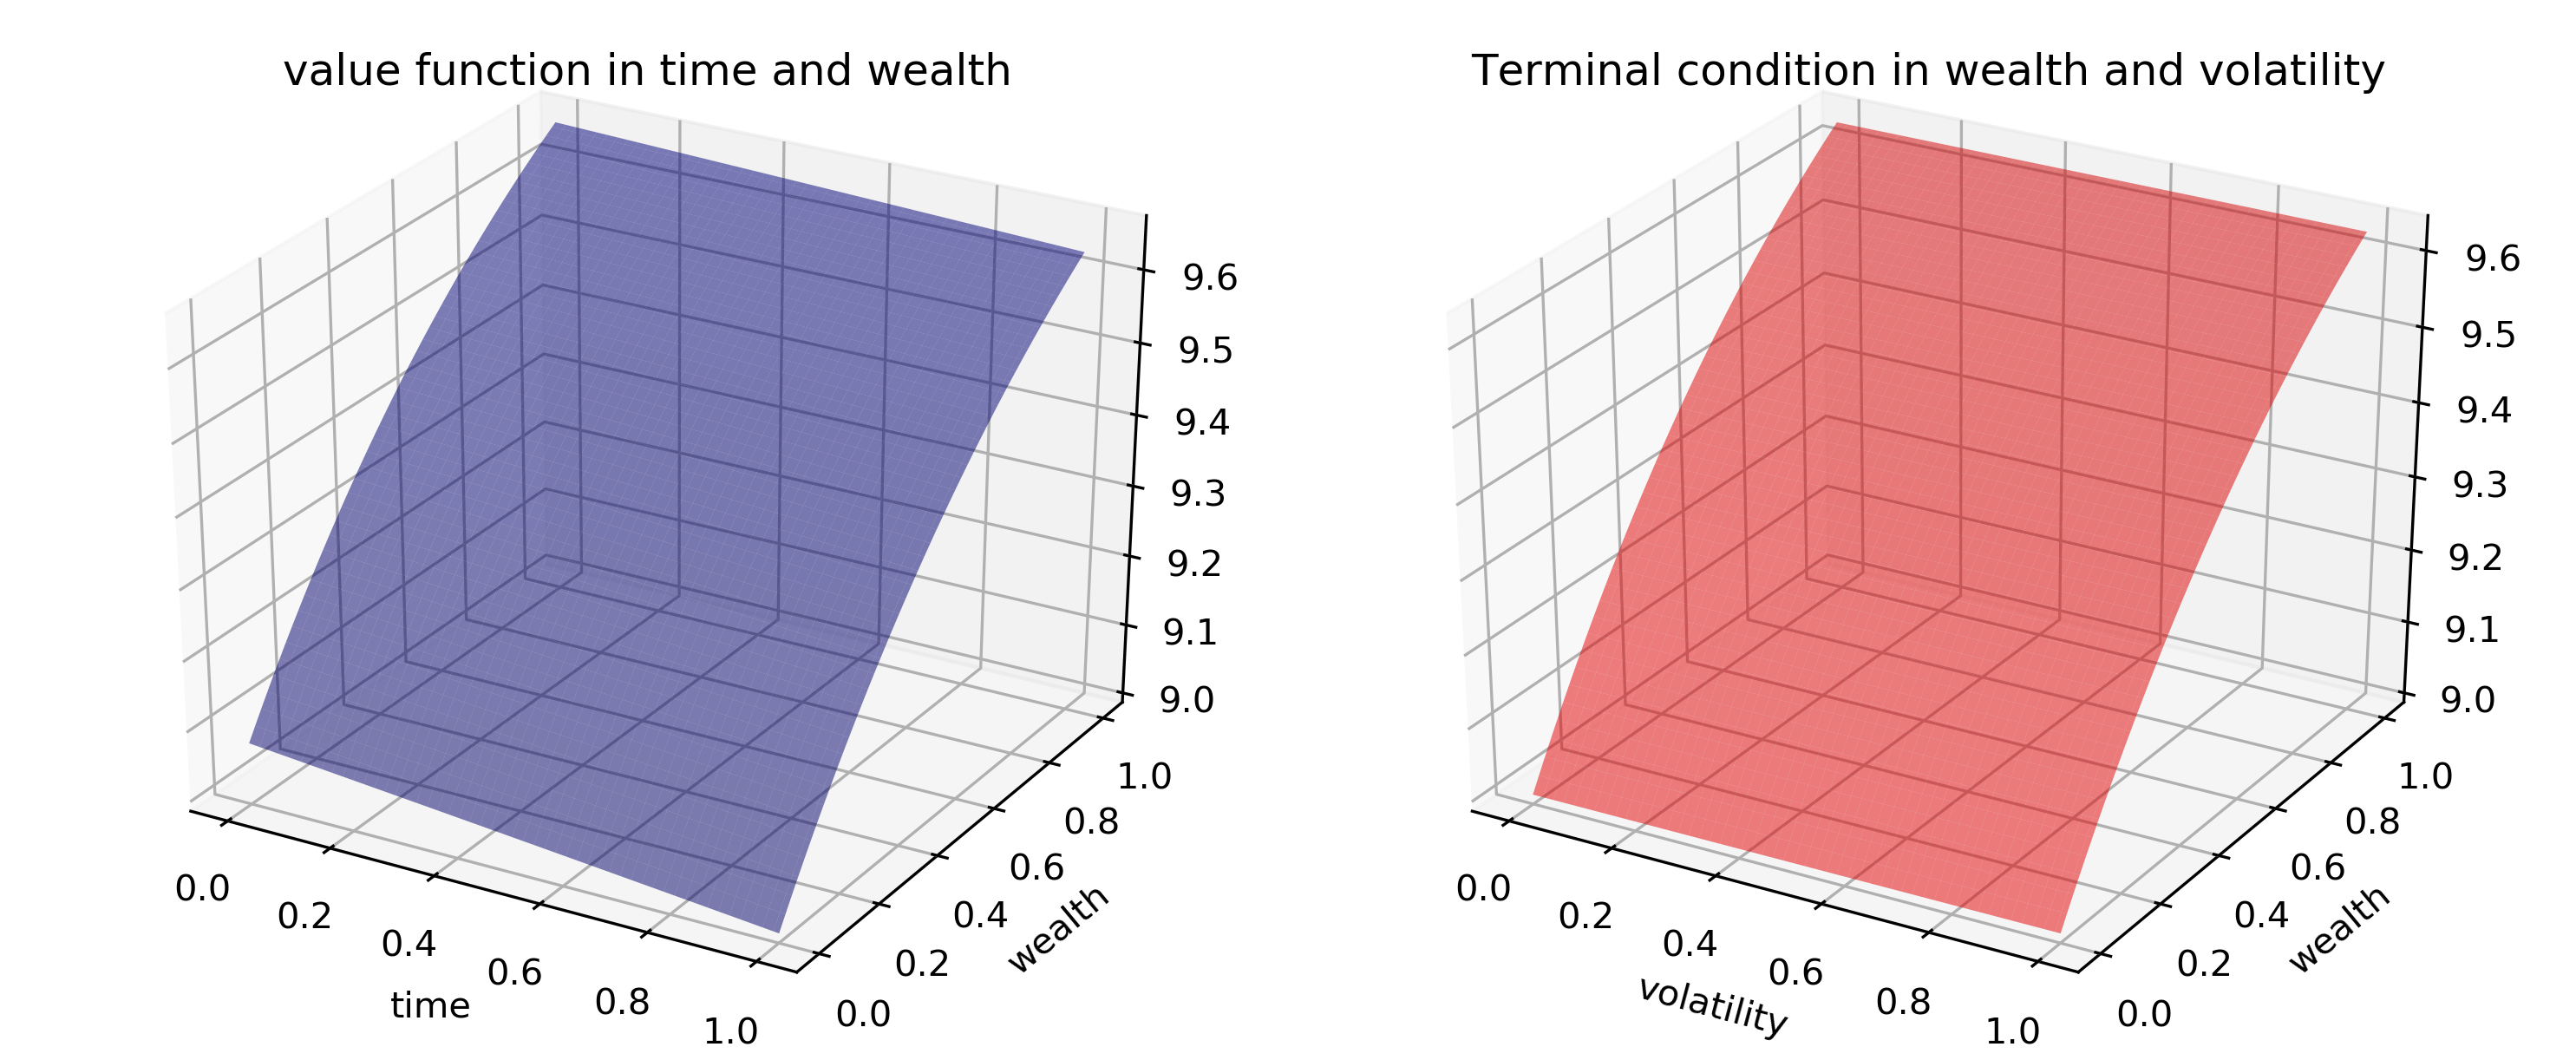

In [56]:
steps =100
x = torch.linspace(0.0,1.,steps=steps)
y = torch.linspace(0.0,1.,steps=steps)
xy = torch.cartesian_prod(x,y)
x, y = torch.meshgrid(x, y, indexing='ij')
v_T = g(xy).detach().reshape(steps,steps).squeeze(-1)
v = sol_exp(xy).detach().reshape(steps,steps).squeeze(-1)
f = plt.figure(figsize=(10,3),dpi=300);
ax0 = f.add_subplot(1, 2, 1, projection='3d')
ax0.plot_surface(x.numpy(),y.numpy(),v.numpy(),color='b',alpha=0.5);
ax0.set_xlabel('time')
ax0.set_ylabel('wealth')
ax0.set_title("value function in time and wealth")

ax1 = f.add_subplot(1, 2, 2, projection='3d')
ax1.plot_surface(y.numpy(),x.numpy(),v_T.numpy(),color='r',alpha=0.5);
ax1.set_ylabel('wealth')
ax1.set_xlabel('volatility');
ax1.set_title("Terminal condition in wealth and volatility")
plt.tight_layout(rect=(-0., -0.2, 1, 1.2));


# Sample generation based using defined coefficients

In [57]:
class data_gen(object):
    def __init__(self,sigma,mu,pde,sim):
        self.mu = mu
        self.sigma = sigma
        a = sim['start']
        b = sim['end']
        iid = sim['iid']
        num_samples = sim['num_samples']
        n = sim['num_time_intervals']
        dim = pde['dim']
        self.dt = torch.tensor([pde['T']/sim['num_time_intervals']]).to(device)
        dw = iid[0:num_samples*dim*n].reshape([num_samples,dim,n]).to(device)* torch.sqrt(self.dt)#you can make randomness a universal variable if 
        self.x = torch.zeros((num_samples,dim+1,n+1))
        
        self.x[:,1:,0]= a+(b-a)*torch.rand(num_samples,dim).to(device)  
        self.sigmadw = torch.zeros((num_samples,dim,n)).to(device)
        for i in range(n):
            self.sigmadw[:,:,i] = torch.bmm(self.sigma(self.x[:,:,i]).reshape((num_samples,dim,dim)),dw[:, :, i].unsqueeze(2)).squeeze(2)
            self.x[:,1:,i+1] = self.x[:,1:,i] + self.mu(self.x[:,:,i])*self.dt + self.sigmadw[:,:,i]
            self.x[:,0,i+1] = self.x[:,0,i]+self.dt

In [58]:
v = sample_Znet()
s = sigma1D(pde_params)
sigma = NN_diff_1D(pde_params,diff = s)
mu = OU_drift_lin(pde_params,v,sigma)
a = torch.tensor([0.0])
b = torch.tensor([1.0])
T = pde_params['T']
n = 20
num_samples = 2**14

In [59]:
sigma(input).shape

torch.Size([2, 2, 2])

In [60]:
data = data_gen(sigma,mu,pde_params,sim_params)
data.x.shape

torch.Size([16384, 3, 21])

# Testing different update methods

# Solving linear equations

$\begin{cases}-\partial v_t - \dfrac12 (\sigma^\intercal\sigma): D^2v -\mu\cdot\nabla v + f(t,x) =0\\
v(T,x)=g(x)
\end{cases}$

$\sigma(t,x)$ has shape [num_samples,dim,dim]
$dW_t$  has shape [num_samples,dim]

We need to unsqueeze $dW_t$ before batch multiplication.

    
    torch.bmm(sigma(x[:,:,i]),dw[:, :, i]dw[:, :, i].unsqueeze(2))



In [61]:
class linear(object):
    def __init__(self,sigma,mu,source,kappa,terminal,pde,sim):        
        self.Y0 = Ynet() # NN for value at t=0 
        self.Z = Znet() # NN for gradient at all tims 
        self.terminal = terminal # terminal condition
        self.loss_epoch = [] # list to keep the loss at each training epoch
        self.num_epochs = 5000 # total number of epochs
        self.epoch=0 # initializing epoch to zero
        self.mu = mu # drift of the SDE
        self.sigma = sigma # diffusion coef. for SDE
        self.kappa = kappa # discount factor
        self.source = source # source term for the PDE
        self.n = sim['num_time_intervals'] # number of time intervals
        # self.num_samples = sim['num_samples'] # number of samples 
        data = data_gen(sigma,mu,pde,sim)
        self.dt = data.dt.to(device)
        self.x = data.x.to(device).clone().detach()
        self.sigmadw = data.sigmadw.to(device).clone().detach()
        self.r = torch.ones((self.x.shape[0],1,n+1)).to(device)
        self.c = torch.ones((self.x.shape[0],1,n+1)).to(device)
        for i in range(self.n):
            self.r[:,:,i+1] = self.r[:,:,i]* torch.exp(-self.kappa(self.x[:,:,i])*self.dt)
            if i == self.n -1 :
                self.c[:,:,i+1] = self.terminal(self.x[:,1:,i+1])
            self.c[:,:,i] = self.source(self.x[:,:,i])
        self.r = self.r.clone().detach()
        self.c = self.c.clone().detach()
        
    def loss(self):
        # self.Zsigmadw = torch.zeros((num_samples,1,n)).to(device)
        for i in range(self.n):   
            if i == 0:
                Y =  self.Y0(self.x[:,1:,0])
            else:
                # self.Zsigmadw[:,:,i] = torch.bmm(self.Z(self.x[:,:,i]).unsqueeze(1),self.sigmadw[:,:,i].unsqueeze(2)).squeeze(2)
                Y = Y*self.r[:,:,i] - self.c[:,:,i]*self.dt + torch.bmm(self.Z(self.x[:,:,i]).unsqueeze(1),self.sigmadw[:,:,i].unsqueeze(2)).squeeze(2)
        return torch.pow(self.c[:,:,-1]-Y,2).mean()
        
    def train(self,lr):
        t_0 = time.time()
        self.lr = lr
        parameters = list(self.Y0.parameters()) + list(self.Z.parameters())
        optimizer = optim.Adam(parameters, self.lr)
        L_ = torch.Tensor([-2.0])
        loss = torch.Tensor([2.0])
        while (torch.abs(L_-loss)>1e-10) & (self.epoch < self.num_epochs):# epoch in range(num_epochs):
            t_1 = time.time()
            optimizer.zero_grad()
            loss= self.loss()#self.cost(self.X,self.modelu(X))+ torch.mean(self.terminal(update(self.X,self.modelu(X))))#
            loss.backward()
            optimizer.step()
            self.loss_epoch.append(loss)
            if self.epoch>0:
                L_ = self.loss_epoch[self.epoch-1]
            if (self.epoch % int(self.num_epochs/10)== int(self.num_epochs/10)-1):
                print("At epoch {} the mean error is {:.2E}.".format(self.epoch+1,loss.detach()))
                self.time_display(t_0, t_1)
            self.epoch += 1
        print("Training took {} epochs.".format(self.epoch))

    def time_display(self, t_0, t_1):
        print("Training this epoch takes {:,} ms.".format(round(1000*(time.time()-t_1),2)))
        print("So far: {:,} ms in training.".format(round(1000*(time.time()-t_0),2)))

In [62]:
# v = sample_Znet()
s = sigma1D(pde_params)
# sigma = NN_diff_1D(pde_params,diff = s) 
sigma = constant_diff(pde_params)
# mu = OU_drift_lin(pde_params,v,sigma)
mu = OU_drift_semi(pde_params)
k = zero_discount(pde_params)
f = zero_source(pde_params)
g = terminal(pde_params)
a = sim_params['start']
b = sim_params['end']

In [63]:
heat = linear(sigma,mu,f,k,g,pde_params,sim_params)

In [64]:
heat.train(lr=1e-2)

At epoch 500 the mean error is 4.00E-02.
Training this epoch takes 277.01 ms.
So far: 252582.73 ms in training.


In [ ]:
plt.plot([l.detach().numpy() for l in heat.loss_epoch]);

In [ ]:
plt.plot(np.log(np.arange(len(heat.loss_epoch))+1),[np.log(l.detach().numpy()) for l in heat.loss_epoch]);

## Plot value function

In [ ]:
def display_it(eqn):
    sol_exp = solution(pde_params0)
    if dim == 2:
        steps =100
        x = torch.linspace(0.0,1.,steps=steps)
        y = torch.linspace(0.0,1.,steps=steps)
        xy = torch.cartesian_prod(x,y)
        txy = torch.cat((torch.zeros(xy.shape[0],1),xy),axis=1)
        # v_T = eqn.terminal(xy).detach().reshape(steps,steps).squeeze(-1)
        v = eqn.Y0(xy).detach().reshape(steps,steps).squeeze(-1)
        v_0 = sol_exp(txy).detach().reshape(steps,steps).squeeze(-1)
        f,ax = plt.subplots(1,1,figsize=(5,5),dpi=300);
        ax = plt.axes(projection='3d')
        X, Y = torch.meshgrid(x, y, indexing='ij')
        surf = ax.plot_surface(X.numpy(),Y.numpy(),v.numpy(),alpha=0.5,label="approximation");
        surf = ax.plot_surface(X.numpy(),Y.numpy(),v_0.numpy(),color='r',alpha=0.5,label='closed-form');
        ax.set_xlabel('wealth')
        ax.set_ylabel('volatility');
        # surf._facecolors2d = surf._facecolors3d
        # surf._edgecolors2d = surf._edgecolors3d
        # ax.legend();
        plt.tight_layout(rect=[0,0,1,1]);      
    data = torch.rand(2**14,dim)
    v = eqn.Y0(data).detach().squeeze(-1)
    tdata = torch.cat((torch.zeros(data.shape[0],1),data),axis=1)
    v_0 = sol_exp(tdata).detach().squeeze(-1)
    print("The MSE is {:.3E}.".format(pow(v-v_0,2).mean()))  



In [ ]:
display_it(heat);

## Testing update of $\sigma_n$

In [ ]:
sigma_1 = NN_diff_1D(pde_params,diff = sigma, update = u)

# Solving semilinear equatoins

In [ ]:
class semilinear(object):
    def __init__(self,sigma,mu,F,kappa,terminal,pde,sim):
        self.Y0 = Ynet() # NN for value at t=0 
        self.Z = Znet() # NN for gradient at all tims 
        self.terminal = terminal # terminal condition
        self.loss_epoch = [] # list to keep the loss at each training epoch
        self.num_epochs = 5000 # total number of epochs
        self.epoch=0 # initializing epoch to zero
        self.mu = mu # drift of the SDE
        self.sigma = sigma # diffusion coef. for SDE
        self.kappa = kappa # discount factor
        self.F = F # nonlinear term for the PDE
        self.n = sim['num_time_intervals'] # number of time intervals
        # self.num_samples = sim['num_samples'] # number of samples 
        data = data_gen(sigma,mu,pde,sim)
        self.num_samples = sim['num_samples']
        self.dt = data.dt.to(device)
        self.x = data.x.to(device).clone().detach()
        self.sigmadw = data.sigmadw.to(device).clone().detach()
        self.r = torch.ones((self.x.shape[0],1,n+1)).to(device)
        self.c = torch.ones((self.x.shape[0],1,n+1)).to(device)
        self.sigmax = torch.ones((self.x.shape[0],dim,dim,n)).to(device)
        for i in range(self.n):
            self.r[:,:,i+1] = self.r[:,:,i]* torch.exp(-self.kappa(self.x[:,:,i])*self.dt)
            self.sigmax[:,:,:,i] = self.sigma(self.x[:,:,i]).reshape((self.num_samples,dim,dim))
        self.r = self.r.clone().detach()
        self.c = self.c.clone().detach()
        
        
    def loss(self):
        c = torch.zeros((self.num_samples,1,self.n+1)).to(device)
        for i in range(self.n):   
            if i == 0:
                Y =  self.Y0(self.x[:,1:,0])
            else:
                if i == self.n - 1:
                    c[:,:,i+1] = self.terminal(self.x[:,1:,i+1])
                    #evaluate and reuse self.sigma(self.x[:,:,i]).reshape((self.num_samples,dim,dim))[:,0,0] 
                c[:,:,i] = self.F(self.x[:,1:,i].unsqueeze(-1),self.Z(self.x[:,:,i]).unsqueeze(-1),self.sigmax[:,0,0,i]).unsqueeze(-1)
                Y = Y*self.r[:,:,i] + c[:,:,i]*self.dt + torch.bmm(self.Z(self.x[:,:,i]).unsqueeze(1),self.sigmadw[:,:,i].unsqueeze(2)).squeeze(2)
        return torch.pow(c[:,:,-1]-Y,2).mean()
        
    def train(self,lr):
        t_0 = time.time()
        self.lr = lr
        parameters = list(self.Y0.parameters()) + list(self.Z.parameters())
        optimizer = optim.Adam(parameters, self.lr)
        L_ = torch.Tensor([-2.0])
        loss = torch.Tensor([2.0])
        while  (torch.abs(L_-loss)>1e-10) & (self.epoch < self.num_epochs):# 
            t_1 = time.time()
            optimizer.zero_grad()
            loss= self.loss()##
            loss.backward()
            optimizer.step()
            self.loss_epoch.append(loss)
            if self.epoch>0:
                L_ = self.loss_epoch[self.epoch-1]
            if (self.epoch % int(self.num_epochs/10)== int(self.num_epochs/10)-1):
                print("At epoch {} the mean error is {:.2E}.".format(self.epoch+1,loss.detach()))
                self.time_display(t_0,t_1)          
            self.epoch += 1
                
    def time_display(self, t_0, t_1):
        print("Training this epoch takes {} ms.".format(round(1000*(time.time()-t_1),2)))
        print("So far: {} ms in training.".format(round(1000*(time.time()-t_0),2)))
                



In [ ]:
s = constant_diff(pde_params0)
m = OU_drift_semi(pde_params0)
k = zero_discount(pde_params0)
g =terminal(pde_params0)
F = f_driver(pde_params0)

In [ ]:
semi = semilinear(s,m,F,k,g,pde_params,sim_params)

In [ ]:
semi.train(lr=1e-2)

## Plot value function 2D

In [ ]:
display_it(semi)

In [ ]:
plt.plot([l.detach().numpy() for l in semi.loss_epoch]);

In [ ]:
plt.plot(np.log(np.arange(len(semi.loss_epoch))+1),[np.log(l.detach().numpy()) for l in semi.loss_epoch]);

# Testing different update methods

In [ ]:
print this

# Combine both linear and semilinear

In [ ]:
class eqn(object):
    def __init__(self,params,sigma,mu,kappa,terminal): #params=dim,T,n,a,b,num_samples
        self.dim = params['dim']
        self.T = params['T']
        self.num_samples = params['num_samples']
        self.n = params['num_steps']
        self.a = params['a']
        self.b = params['b']
        self.loss_epoch = []
        self.num_epochs = 10000
        self.epoch=0
        self.sigma = sigma         
        self.mu = mu
        self.kappa = kappa 
        self.terminal = terminal
        self.x = torch.zeros((self.num_samples,self.dim+1,self.n+1))
        self.dt = torch.tensor([self.T/self.n]).to(device)
        self.Y0 = Ynet()
        self.Z = Znet()
        self.dw = torch.randn(size=[self.num_samples, self.dim, self.n]).to(device)* torch.sqrt(self.dt)
        self.x[:,1:,0]= self.a+(self.b-self.a)*torch.rand(self.num_samples,self.dim).to(device)
        self.r = torch.ones((self.num_samples,1,self.n+1)).to(device)
        self.sigmadw = torch.zeros((self.num_samples,self.dim,self.n)).to(device)
        for i in range(self.n):
            self.sigmadw[:,:,i] = torch.bmm(self.sigma(self.x[:,:,i]).reshape((self.num_samples,self.dim,self.dim)),self.dw[:, :, i].unsqueeze(2)).squeeze(2)
            self.x[:,1:,i+1] = self.x[:,1:,i] + self.mu(self.x[:,:,i])*self.dt + self.sigmadw[:,:,i]
            self.x[:,0,i+1] = self.x[:,0,i]+self.dt
            self.r[:,:,i+1] = self.r[:,:,i]* torch.exp(-self.kappa(self.x[:,:,i])*self.dt)
        self.x = self.x.clone().detach()
        self.r = self.r.clone().detach()
        self.sigmadw = self.sigmadw.clone().detach()
        
        
    def train(self):
        t_0 = time.time()
        self.lr = 1e-2
        parameters = list(self.Y0.parameters()) + list(self.Z.parameters())
        optimizer = optim.Adam(parameters, self.lr)
        L_ = torch.Tensor([-2.0])
        loss = torch.Tensor([2.0])
        while  (torch.abs(L_-loss)>1e-10) & (self.epoch < self.num_epochs):# epoch in range(num_epochs):
            t_1 = time.time()
            optimizer.zero_grad()
            loss= self.loss()##
            loss.backward()
            optimizer.step()
            self.loss_epoch.append(loss)
            if self.epoch>0:
                L_ = self.loss_epoch[self.epoch-1]
            if (self.epoch % int(self.num_epochs/10)== int(self.num_epochs/10)-1):
                print("At epoch {} the mean loss is {:.2E}.".format(self.epoch+1,loss.detach()))
                self.time_display(t_0,t_1)          
            self.epoch += 1
        print("Training took {} epochs.".format(self.epoch))
            
                
    def time_display(self, t_0, t_1):
        print("Training this epoch takes {:.3E} ms.".format(round(1000*(time.time()-t_1),2)))
        print("So far: {:.3E} ms in training.".format(round(1000*(time.time()-t_0),2)))    

class lin(eqn):
    def __init__(self,params,sigma,mu,kappa,terminal,source):
        self.source = source    
        super(lin,self).__init__(params,sigma,mu,kappa,terminal)
        self.c = torch.zeros((self.num_samples,1,self.n+1)).to(device)
        for i in range(self.n):
            if i == self.n -1 :
                self.c[:,:,i+1] = self.terminal(self.x[:,1:,i+1])
            self.c[:,:,i] = self.source(self.x[:,:,i])
            self.c = self.c.clone().detach()

            
    def loss(self):
        # self.Zsigmadw = torch.zeros((num_samples,1,n)).to(device)
        for i in range(self.n):   
            if i == 0:
                Y =  self.Y0(self.x[:,1:,0])
            else:
                # self.Zsigmadw[:,:,i] = torch.bmm(self.Z(self.x[:,:,i]).unsqueeze(1),self.sigmadw[:,:,i].unsqueeze(2)).squeeze(2)
                Y = Y*self.r[:,:,i] - self.c[:,:,i]*self.dt + torch.bmm(self.Z(self.x[:,:,i]).unsqueeze(1),self.sigmadw[:,:,i].unsqueeze(2)).squeeze(2)
                # print(Y)
        return torch.pow(self.c[:,:,-1]-Y,2).mean()
    
class semi(eqn):
    def __init__(self,params,sigma,mu,kappa,terminal,F):
        self.F = F    
        super(semi,self).__init__(params,sigma,mu,kappa,terminal)

            
    def loss(self):
        c = torch.zeros((self.num_samples,1,self.n+1)).to(device)
        for i in range(self.n):   
            if i == 0:
                Y =  self.Y0(self.x[:,1:,0])
            else:
                if i == self.n - 1:
                    c[:,:,i+1] = self.terminal(self.x[:,1:,i+1])
                c[:,:,i] = self.F.eval(self.x[:,1:,i].unsqueeze(-1),self.Z(self.x[:,:,i]).unsqueeze(-1),self.sigma(self.x[:,:,i]).reshape((self.num_samples,dim,dim))[:,0,0]).unsqueeze(-1)
                Y = Y*self.r[:,:,i] - c[:,:,i]*self.dt + torch.bmm(self.Z(self.x[:,:,i]).unsqueeze(1),self.sigmadw[:,:,i].unsqueeze(2)).squeeze(2)
                # print(Y)
        return torch.pow(c[:,:,-1]-Y,2).mean()        

In [ ]:
x=torch.rand((8,dim+1))
s = NN_diff_1D(pde_params)
m = OU_drift_semi(pde_params)
k = zero_discount(pde_params)
f = zero_source(pde_params)
g = terminal(pde_params)

In [ ]:
lin_eqn = lin(pde_params,s,m,k,g,f)

In [ ]:
lin_eqn.n

In [ ]:
lin_eqn.train()

## Plot value function

In [ ]:
steps =100
x = torch.linspace(0.25,0.75,steps=steps)
y = torch.linspace(0.25,0.75,steps=steps)
xy = torch.cartesian_prod(x,y)
x, y = torch.meshgrid(x, y, indexing='ij')
z_T = lin.terminal(xy).detach().reshape(steps,steps).squeeze(-1)
z = lin.Y0(xy).detach().reshape(steps,steps).squeeze(-1)


In [ ]:
ax = plt.axes(projection='3d')
ax.plot_surface(x.numpy(),y.numpy(),z.numpy());
ax.plot_surface(x.numpy(),y.numpy(),z_T.numpy());


In [ ]:
steps =100
x = torch.linspace(0,1,steps=steps)
y = torch.linspace(0,1,steps=steps)
xy = torch.cartesian_prod(x,y)
x, y = torch.meshgrid(x, y, indexing='ij')
z_T = lin.terminal(xy).detach().reshape(steps,steps).squeeze(-1)
txy = torch.cat((torch.zeros((xy.shape[0],1)),xy),axis=1)
z = lin.Z(txy).detach().reshape(steps,steps,2).squeeze(-1)


In [ ]:
ax = plt.axes(projection='3d')
ax.plot_surface(x.numpy(),y.numpy(),z[:,:,0].numpy());
# ax.plot_surface(x.numpy(),y.numpy(),z_T.numpy());


In [ ]:
ax = plt.axes(projection='3d')
ax.plot_surface(x.numpy(),y.numpy(),z[:,:,1].numpy());
# ax.plot_surface(x.numpy(),y.numpy(),z_T.numpy());


In [ ]:
semi1 = semi(params,s,m,k,expo,F)

In [ ]:
semi1.train()

## Plot value function

In [ ]:
steps =100
x = torch.linspace(0.25,0.75,steps=steps)
y = torch.linspace(0.25,0.75,steps=steps)
xy = torch.cartesian_prod(x,y)
x, y = torch.meshgrid(x, y, indexing='ij')
z_T = semi1.terminal(xy).detach().reshape(steps,steps).squeeze(-1)
z = semi1.Y0(xy).detach().reshape(steps,steps).squeeze(-1)


In [ ]:
ax = plt.axes(projection='3d')
ax.plot_surface(x.numpy(),y.numpy(),z.numpy());
ax.plot_surface(x.numpy(),y.numpy(),z_T.numpy());


In [ ]:
steps =100
x = torch.linspace(0,1,steps=steps)
y = torch.linspace(0,1,steps=steps)
xy = torch.cartesian_prod(x,y)
x, y = torch.meshgrid(x, y, indexing='ij')
z_T = semi1.terminal(xy).detach().reshape(steps,steps).squeeze(-1)
txy = torch.cat((torch.zeros((xy.shape[0],1)),xy),axis=1)
z = semi1.Z(txy).detach().reshape(steps,steps,2).squeeze(-1)


In [ ]:
ax = plt.axes(projection='3d')
ax.plot_surface(x.numpy(),y.numpy(),z[:,:,0].numpy());
# ax.plot_surface(x.numpy(),y.numpy(),z_T.numpy());


In [ ]:
ax = plt.axes(projection='3d')
ax.plot_surface(x.numpy(),y.numpy(),z[:,:,1].numpy());
# ax.plot_surface(x.numpy(),y.numpy(),z_T.numpy());


# Finding second derivative

In [ ]:
import torch
from torch.autograd import grad
 
def test_fn(x):
    return torch.bmm(x.unsqueeze(-1),x.unsqueeze(1)).unsqueeze(-1)

x = torch.tensor([[0.0, 1.0],[1.0,0.0]], requires_grad=True)
 
# Compute the gradient of f with respect to x
def gradiant(x,f):
    return grad(outputs=f(x), inputs=x, grad_outputs=torch.ones_like(f(x)), create_graph=True, retain_graph=True, only_inputs=True)[0]#.unsqueeze(-1)
 
# Print the gradient
print(gradiant(x,test_fn).shape)

In [ ]:
def der1(x,f):  #output= [M,D,1], input: x=[M,D,1]
  Du=torch.zeros(x.shape[0],dim).to(device)
  xin=x.clone().detach()
  xin.requires_grad=True
  # print('xin shape', xin.shape)
  u=f(xin)
  # print(u)
  # print('u/f(xin) shape', u.shape)
  Du=torch.autograd.grad(outputs=[u],inputs=[xin],grad_outputs=torch.ones_like(u),
                          allow_unused=True,retain_graph=True,create_graph=True)[0].unsqueeze(-1)
  # print('Du shape before reshaped', Du.shape)
  Du=torch.reshape(Du,(Du.shape[0],dim,1))
  # print('Du shape after reshaped', Du.shape)
  return Du

In [ ]:
der1(x,test_fn).shape

In [ ]:
def Grad_Hess(x,f_): #output= [M,D,D], #input: x=[M,D], t=[M,1], xt= [M,D+1]
    hess_temp=torch.zeros(x.shape[0],dim,dim).to(device)
    Du=torch.zeros(x.shape[0],dim).to(device)
    xin=x[:,1:].clone().detach()
    xin.requires_grad=True
    u=f_(xin)
    Du=torch.autograd.grad(outputs=[u],inputs=[xin],grad_outputs=torch.ones_like(u),
                           allow_unused=True,retain_graph=True,create_graph=True)[0].unsqueeze(2)
    hess_temp= torch.cat([ torch.autograd.grad(outputs=[Du[:,i,:]],inputs=[xin],grad_outputs=torch.ones_like(Du[:,i,:]),
                           allow_unused=True,retain_graph=True,create_graph=True)[0] for i in range(dim)],1)
    Du = torch.reshape(Du,(Du.shape[0],dim,1))
    # print("Du after reshape:",Du.shape)
    hess_temp=torch.reshape(hess_temp,(hess_temp.shape[0],dim,dim))
    return Du, hess_temp


In [ ]:
semi1.x[:,:,0].squeeze(-1).shape,x.shape

In [ ]:
x = torch.tensor([[0.0,0.0,1.0],[0.0,1.0,0.0],[0.0,1.4,0.7]], requires_grad=True)
Grad_Hess(semi1.x[:,:,0],semi1.Y0)[1].mean()

# test second derivative with NN

<font color="red" size="4">Batch normaizations srews up the derivative.</font>

In [ ]:
def Hess(x,f_): #output= [M,D,D], #input: x=[M,D]
    dim = x.shape[1]
    hess_temp=torch.zeros(x.shape[0],dim,dim).to(device)
    Du=torch.zeros(x.shape[0],dim).to(device)
    xin=x.clone().detach()
    xin.requires_grad=True
    u=f_(xin)
    Du=torch.autograd.grad(outputs=[u],inputs=[xin],grad_outputs=torch.ones_like(u),
                           allow_unused=True,retain_graph=True,create_graph=True)[0].unsqueeze(2)
    hess_temp= torch.cat([ torch.autograd.grad(outputs=[Du[:,i,:]],inputs=[xin],grad_outputs=torch.ones_like(Du[:,i,:]),
                           allow_unused=True,retain_graph=True,create_graph=True)[0] for i in range(dim)],1)
    Du = torch.reshape(Du,(Du.shape[0],dim,1))
    # print("Du after reshape:",Du.shape)
    hess_temp=torch.reshape(hess_temp,(hess_temp.shape[0],dim,dim))
    return Du, hess_temp

In [ ]:
class NN1d(nn.Module): #input [M,D+1]   #output [M,1]
    def __init__(self):
        super(NN1d, self).__init__()
        self.linear_stack = nn.Sequential(
            nn.Linear(1, 20),
            # nn.BatchNorm1d(num_features=20),
            nn.Tanh(),
            nn.Linear(20,1),
        )
    def forward(self, x):
        logits = self.linear_stack(x)
        return logits#.reshape([dim,dim]) 

In [ ]:
test_fn = NN1d()

In [ ]:
x_tr = torch.rand(100,1)
# x_tr = torch.rand(0,1,100).unsqueeze(-1)
y_tr = x_tr*x_tr

In [ ]:
num_epochs = 100000
lr = 1e-2
optimizer = optim.Adam(test_fn.parameters(), lr)
L_ = torch.Tensor([-2.0])
loss = torch.Tensor([2.0])
epoch=0
while  (torch.abs(L_-loss)>1e-8) & (epoch < num_epochs):# epoch in range(num_epochs):
    optimizer.zero_grad()
    loss= torch.pow(y_tr-test_fn(x_tr),2).mean()##
    loss.backward()
    optimizer.step()
    if (epoch % int(num_epochs/10)== int(num_epochs/10)-1):
        print("At epoch {} the mean loss is {}.".format(epoch+1,loss.detach()))
    epoch += 1

In [ ]:
x_ts = torch.linspace(0,1,100).unsqueeze(-1)
plt.plot(x_ts.detach().numpy(),test_fn(x_ts).detach().numpy());
plt.plot(x_ts.detach().numpy(),x_ts*x_ts.detach().numpy());

In [ ]:
xin = x_ts.clone().detach()
xin.requires_grad=True
dy = gradiant(xin,test_fn).squeeze(-1)
dy.shape

In [ ]:
# plt.plot(x_tr.detach().numpy(),test_fn(x_tr).detach().numpy());
plt.plot(x_ts.detach().numpy(),dy.detach().numpy());

In [ ]:
gradiant(torch.tensor([[1.0],[0.5],[0.0]],requires_grad=True),test_fn)

In [ ]:
ddy = Hess(x_ts,test_fn)[1].squeeze(-1)
plt.plot(x_ts.detach().numpy(),ddy.detach().numpy());

${\color{red}\text{It does not matter if the second derivative is not accurate. } \ell^2  \text{ will be positive and the direction is always a direction of increase.}}$